# Twitter NLP를 이용한 ETH alpha

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import ccxt

In [3]:
from tqdm import tqdm

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer as nltksent
from transformers import pipeline
import torch

c:\Users\chlje\VSCodeProjects\qtrsch\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from functools import partial

In [5]:
from pathlib import Path

CWD = Path('.').resolve()
PROJECT_PATH = CWD.parent
VENV_PATH = PROJECT_PATH / '.venv'

NLTK_PATH = VENV_PATH / 'nltk_data'

In [6]:
NLTK_PATH

WindowsPath('C:/Users/chlje/VSCodeProjects/qtrsch/.venv/nltk_data')

In [7]:
import os
os.environ['NLTK_DATA'] = NLTK_PATH.absolute().as_posix()

import nltk

nltk.download('vader_lexicon', download_dir=NLTK_PATH)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chlje\VSCodeProjects\qtrsch\.venv\nltk_data..
[nltk_data]     .
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## `ccxt`를 활용하여 ETH 분봉 가져오기 

In [8]:
binance = ccxt.binance()

In [9]:
timeframe = '1m' # 1 minute

START_DATE = binance.parse8601('2024-05-01T00:00:00Z')
END_DATE = binance.parse8601('2024-07-17T23:59:59Z')

symbol = 'ETH/USDT'


In [10]:
ohlcv = []
since = START_DATE
while True:
    data = binance.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
    if not data:
        break
    ohlcv.extend(data)
    since = data[-1][0] + 60 * 1000  # Move to the next minute
    if since >= END_DATE:
        break

In [11]:
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [33]:
df.set_index('timestamp', inplace=True)

<Axes: xlabel='timestamp'>

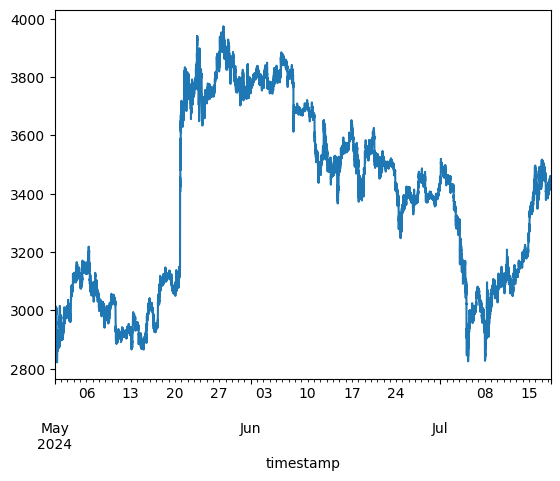

In [35]:
df['close'].plot()

## twitter 데이터에서 알파 뽑아내기

In [14]:
tweets_df = pd.read_pickle('ETH_tweets.pkl')

In [15]:
# 여기선 timestamp와 full_text만 사용

tweets_df = tweets_df[['created_at', 'full_text']].copy()
tweets_df.set_index('created_at', inplace=True)

### tweet count (raw signal)

### tweet sentiment (nltk)

In [16]:
def get_sentiment_nltk(text):
    nltk_analyzer = nltksent()
    sentiment_dict = nltk_analyzer.polarity_scores(text)
    return sentiment_dict['compound']

In [17]:
tweets_df['sentiment_nltk'] = tweets_df['full_text'].apply(get_sentiment_nltk)

### tweet sentiment (hugginface pipeline)

In [21]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [25]:
def get_sentiment_transformers(text, model_name):
    try:
        sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
        result = sentiment_pipeline(text)[0]
        score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
        return score
    except Exception as e:
        print(e)
        return np.nan

In [26]:
partial_get_sentiment_transformers = partial(get_sentiment_transformers, model_name=model_name)

In [27]:
tweets_df['sentiment_transformers'] = tweets_df['full_text'].apply(partial_get_sentiment_transformers)

The expanded size of the tensor (870) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 870].  Tensor sizes: [1, 514]


### tweet sentiment (LLM)

In [29]:
tweets_df.to_pickle('tweets_with_sentiment.pkl')

## Plot

<Axes: xlabel='created_at'>

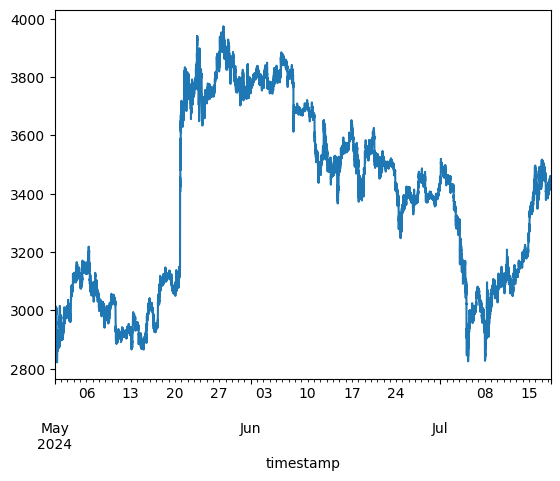

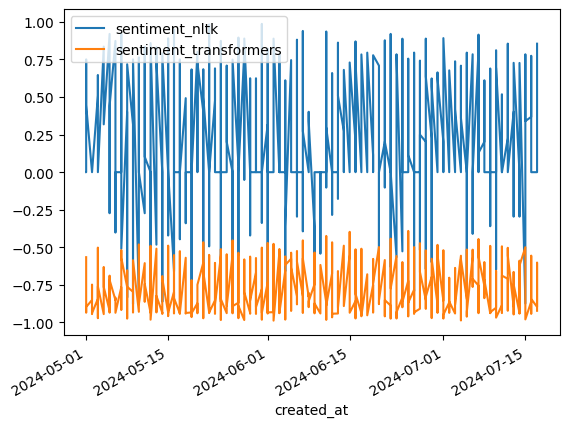

In [36]:
df['close'].plot()
tweets_df.plot(y=['sentiment_nltk', 'sentiment_transformers'])